![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 11 - RNN </center>
### <center> Vanilla RNN </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/11_RNN/MainVanillaRNN.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

For Colab users:

In [2]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/11_RNN/DeepLearningFramework ./DeepLearningFramework

In [3]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn          as nn
import torch.optim       as optim

### PyTorch `PackedSequence`:

In [4]:
from torch.nn.utils.rnn import pack_sequence

v1 = torch.tensor([1, 2, 3])
v2 = torch.tensor([4])
v3 = torch.tensor([5, 6])
lV = [v1, v2 ,v3]

pack = pack_sequence(lV, enforce_sorted=False)
print('pack.data          :', pack.data)
print('pack.batch_sizes   :', pack.batch_sizes)
print('pack.sorted_indices:', pack.sorted_indices)

pack.data          : tensor([1, 5, 4, 2, 6, 3])
pack.batch_sizes   : tensor([3, 2, 1])
pack.sorted_indices: tensor([0, 2, 1])


### Basic example
* Random data with random length.
* The goal is to estimate the sequence's length.

#### Generate data:

In [5]:
#-- Min and max lengths:
minL   = 2
maxL   = 100

nTrain = 50000
nTest  = 10000
N      = nTrain + nTest

#-- Generate random lengths:
lX = [None] * N
vY = torch.randint(minL, maxL, (N,))
for ii in range(N):
    vXi    = torch.randn(vY[ii], 1)
    lX[ii] = vXi

#### Dataset:

In [6]:
#-- A simple sequence dataset:
if False:
    class SequenceDataset(torch.utils.data.Dataset):
        def __init__(self, lX, vY):
            self.lX = lX
            self.vY = vY

        def __len__(self):
            return len(self.lX)

        def __getitem__(self, idx):
            vXi = self.lX[idx]
            yi  = self.vY[idx]
            return vXi, yi

In [7]:
from DeepLearningFramework.RNNUtils import SequenceDataset
from torch.utils.data               import random_split

oDataset            = SequenceDataset(lX, vY.float())
oTrainSet, oTestSet = random_split(oDataset, [nTrain, nTest])

len(oTrainSet), len(oTestSet)

(50000, 10000)

#### Data loader:
We gonna use `zip` to implement the `collate_fn`

In [8]:
l = [('x1', 'y1'), ('x2', 'y2'), ('x3', 'y3')]
l1, l2 = zip(*l)
l1, l2

(('x1', 'x2', 'x3'), ('y1', 'y2', 'y3'))

In [9]:
if False:
    def SequenceCollate(lBatch):

        lX, lY = zip          (*lBatch)
        vY     = torch.stack  (lY)
        mPackX = pack_sequence(lX, enforce_sorted=False)

        return mPackX, vY

In [10]:
from DeepLearningFramework.RNNUtils import SequenceCollate

batchSize = 128
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=1*batchSize, collate_fn=SequenceCollate, num_workers=2, persistent_workers=True)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, collate_fn=SequenceCollate, num_workers=2, persistent_workers=True)

In [11]:
mPackX, vY = next(iter(oTrainDL))
mPackX, vY.shape

(PackedSequence(data=tensor([[0.6216],
         [0.1316],
         [1.3312],
         ...,
         [1.6493],
         [1.3187],
         [0.1531]]), batch_sizes=tensor([128, 128, 127, 126, 126, 126, 125, 122, 121, 121, 120, 120, 118, 117,
         115, 115, 114, 114, 113, 111, 110, 107, 104, 104, 104,  99,  99,  97,
          96,  93,  93,  91,  91,  91,  89,  88,  84,  82,  81,  81,  78,  77,
          75,  75,  74,  73,  71,  70,  70,  68,  68,  68,  64,  61,  60,  58,
          55,  54,  53,  53,  50,  48,  46,  46,  45,  41,  40,  39,  36,  34,
          33,  33,  33,  33,  32,  30,  30,  30,  30,  28,  27,  26,  23,  21,
          20,  18,  17,  17,  17,  14,  10,   9,   8,   7,   6,   5,   5,   4,
           3]), sorted_indices=tensor([ 88, 110, 117,  35, 120, 101, 114,  63,  18,  27,   6,  34,  70, 106,
          19,  60,  68,  20,  91, 115, 126,   8,   9,  43,  15, 111,  48, 122,
          81,  94, 123,   1,  17,  45,  32, 107,  13, 116,  51,  97,  42,  85,
          61,  44, 

### RNN Model:

In [12]:
class RnnModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        H            = 64
        self.oRnn    = nn.RNN   (input_size=1, hidden_size=H, batch_first=True)
        self.oLinear = nn.Linear(H, 1)

    def forward(self, mPackX):
                                      #-- mPackX.shape = (N*T,)
        _, mH  = self.oRnn   (mPackX) #-- mH    .shape = (1, N, H)
        vY     = self.oLinear(mH[0])  #-- vY    .shape = (N, 1)
        
        return vY[:,0]
#-------------------------------------------------------------------------------#
#-------------------------------------------------------------------------------#
mPackX, vY = next(iter(oTrainDL))

RnnModel()(mPackX).shape

torch.Size([128])

#### Device, loss, metric:

In [13]:
from DeepLearningFramework.Metric import R2Score

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
Loss   = nn.MSELoss()
Metric = R2Score

### Train the model:

In [14]:
from torch.optim.lr_scheduler       import OneCycleLR
from DeepLearningFramework.Training import TrainModel

nEpochs    = 30
nIter      = nEpochs * len(oTrainDL)

oModel     = RnnModel  ().to(DEVICE)
oOptim     = optim.Adam(oModel.parameters(), lr=0, betas=(0.8, 0.9))
oScheduler = OneCycleLR(oOptim, max_lr=5e-4, total_steps=nIter)
lHistory   = TrainModel(oModel, oTrainDL, oTestDL, Loss, Metric, nEpochs, oOptim, oScheduler);

------------------------------------------------------------------------------------------------------------------------
Epoch 000: | Train loss: 3326.257 | Val loss: 3319.704 | Train Metric: -3.195 | Val Metric: -3.107 | epoch time: 13.869 | <-- Checkpoint!
Epoch 001: | Train loss: 3154.857 | Val loss: 3018.966 | Train Metric: -2.981 | Val Metric: -2.735 | epoch time:  2.738 | <-- Checkpoint!
Epoch 002: | Train loss: 2843.662 | Val loss: 2716.689 | Train Metric: -2.592 | Val Metric: -2.361 | epoch time:  2.751 | <-- Checkpoint!
Epoch 003: | Train loss: 2518.446 | Val loss: 2344.302 | Train Metric: -2.176 | Val Metric: -1.900 | epoch time:  2.819 | <-- Checkpoint!
Epoch 004: | Train loss: 2289.915 | Val loss: 1923.153 | Train Metric: -1.883 | Val Metric: -1.378 | epoch time:  2.624 | <-- Checkpoint!
Epoch 005: | Train loss: 2132.607 | Val loss: 1549.578 | Train Metric: -1.691 | Val Metric: -0.916 | epoch time:  2.702 | <-- Checkpoint!
Epoch 006: | Train loss: 2770.964 | Val loss: 1366.

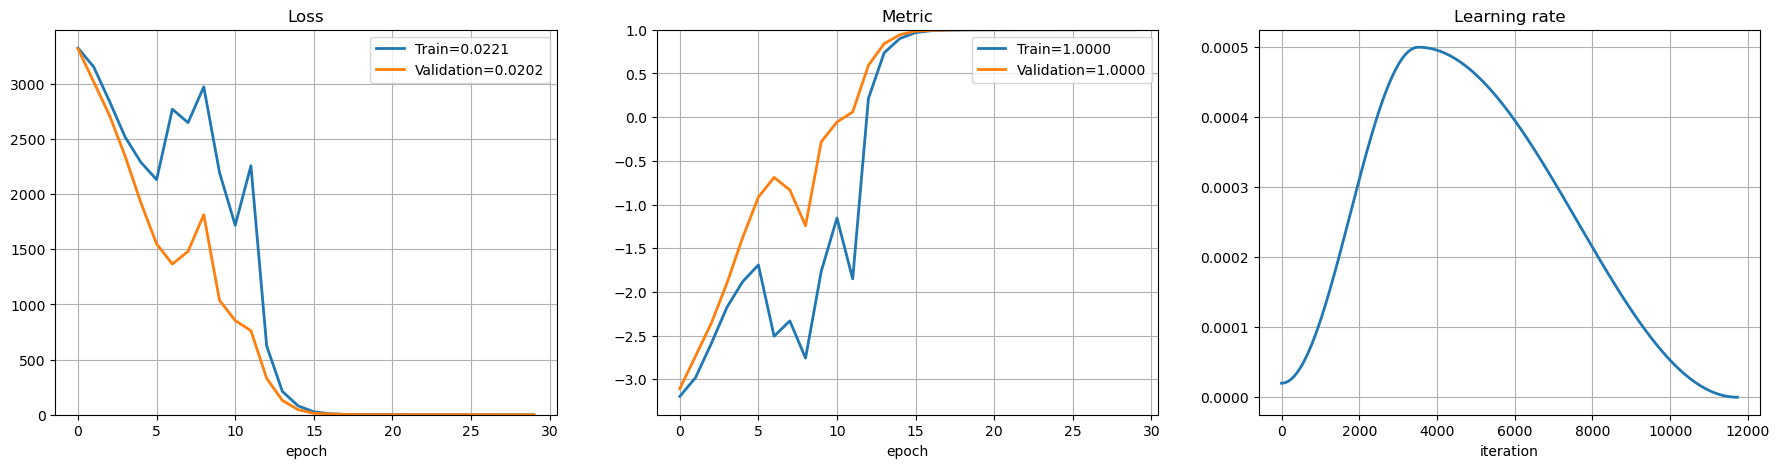

In [15]:
from DeepLearningFramework.Auxiliary import PlotHistory

PlotHistory(lHistory)
plt.show   ()

### Test the model:

In [16]:
L  = np.random.randint(minL, maxL)
vX = pack_sequence([torch.randn(L, 1)])
y  = oModel(vX.to(DEVICE))

print(f'Sequence length           = {L}')
print(f'Estimated sequence length = {y.item()}')

Sequence length           = 6
Estimated sequence length = 5.9457807540893555


### Exercise
* The goal is to estimate the following function:
![f_x](https://github.com/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/11_RNN/f_x.png?raw=true)
* Train an RNN model and get $R^2$ above `0.99`.

#### Generate data:

In [17]:
minL   = 5
maxL   = 30
nTrain = 50000
nTest  = 10000
N      = nTrain + nTest

vY = torch.zeros(N)
lX = [None] * N
for ii in range(N):
    L       = np.random.randint(minL, maxL)
    vX      = torch.rand(L, 1)
    idx     = np.random.randint(L)
    vX[idx] = -1
    lX[ii]  = vX
    vY[ii]  = torch.sum(vX[:idx]**2) - torch.sum(vX[idx+1:]**2)

#### Split to train and test:

In [ ]:
oDataset            = SequenceDataset(lX, vY.float())
oTrainSet, oTestSet = ???

len(oTrainSet), len(oTestSet)

In [ ]:
batchSize = ???
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=1*batchSize, collate_fn=???)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, collate_fn=???)

### Model:

In [ ]:
class RnnModel(nn.Module):
    def __init__(self):
        super(RnnModel, self).__init__() #-- always do this
        
        H            = 100
        self.oRnn    = nn.RNN   (input_size=1, hidden_size=H, batch_first=True)
        self.oLinear = nn.Linear(H, 1)

    def forward(self, mPackX):
        ???

#-------------------------------------------------------------------------------#
#-------------------------------------------------------------------------------#
mPackX, vY = next(iter(oTrainDL))

RnnModel()(mPackX).shape

In [ ]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
Loss   = ???
Metric = ???

In [ ]:
nEpochs       = 30
nIter         = nEpochs * len(oTrainDL)
oModel        = RnnModel().to(DEVICE)
oOptim        = ???
oScheduler    = ???
lHistory      = TrainRegressionModel(oModel, oTrainDL, oTestDL, Loss, Metric, nEpochs, oOptim, oScheduler);

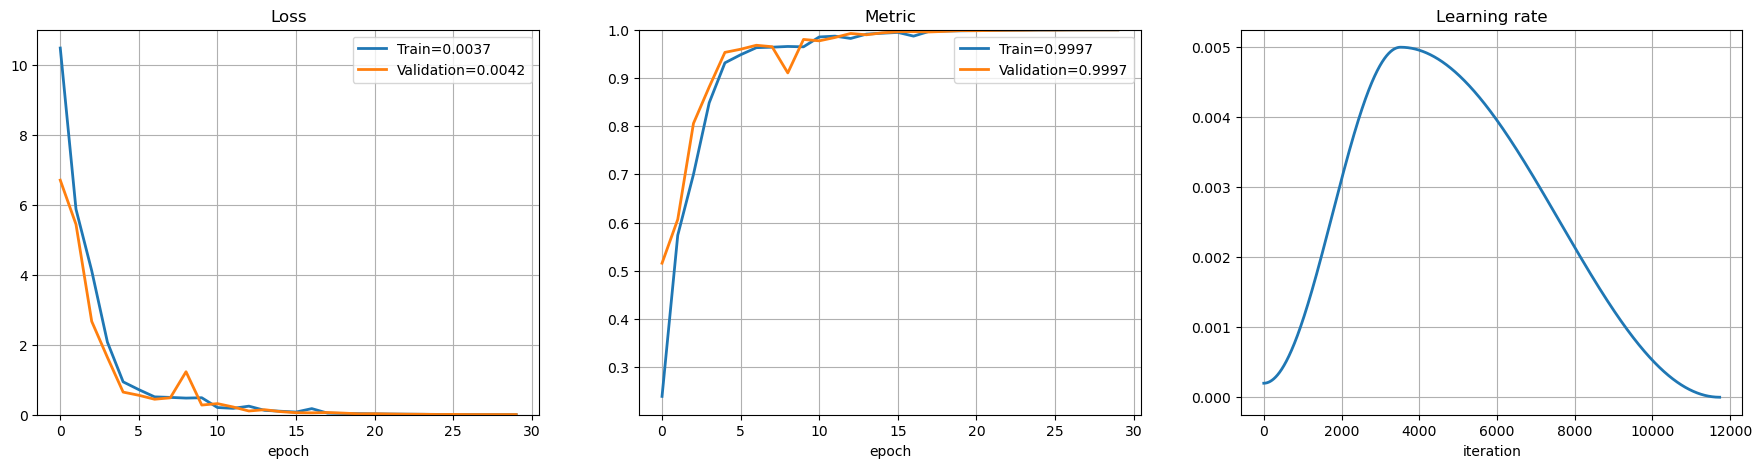

In [12]:
PlotHistory(lHistory)
plt.show   ()